# COVID-19 CT Image Classification Using PyTorch



## Overview

1. Data Preparation
2. Initial Model Development
3. Model Performance Using Data Augmentation
4. Transfer Learning

## 1. Data Preparation

* Import dependecies
* Extract file paths and split into training, validation, and test partitions
* Create Dataset Class to process and load images for PyTorch models 

### 1.1 Import all dependencies

In [1]:
import os  
import glob
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import PIL 
import random
import numpy as np
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
from torchinfo import summary 

import torch.optim as optim
from IPython.display import Image
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.nn.functional as F


import cv2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

Set Random Seed for reproducability

In [3]:
random_seed = 124
np.random.seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

### 1.2 Generating Labels and Creating Sets for Modeling

Extract file links for both postive and negative images and split the dataset into train, validation, and test sets

In [4]:
path = 'C:/Users/Lucas/PIBIC/archive'

pos_files = glob.glob(os.path.join(path, "CT_COVID",'*.*'))
neg_files = glob.glob(os.path.join(path, 'CT_NonCOVID','*.*'))

images = pos_files + neg_files
labels = np.array([1]*len(pos_files)+[0]*len(neg_files))

images_tv, images_test, y_tv, y_test  = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=123)
images_train, images_val, y_train, y_val  = train_test_split(images_tv, y_tv, shuffle=True, test_size=0.25, random_state=123)

From the plot below, observe that we have a balanced yet very small dataset at our disposal. Not ideal, but never the end of the road. Let's do our best to make the most out of what we have before we collect more data.

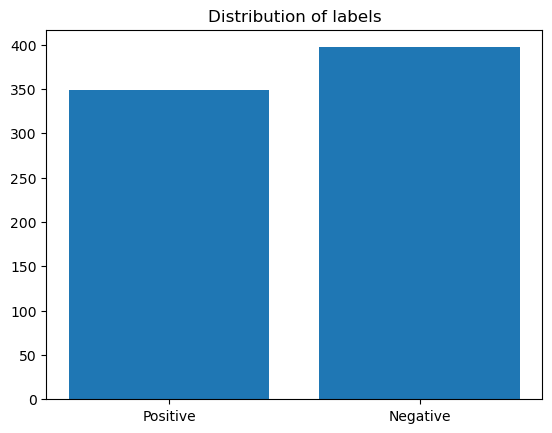

In [5]:
num_pos, num_neg = len(pos_files), len(neg_files)

plt.title('Distribution of labels')
plt.bar(['Positive', 'Negative'], [num_pos, num_neg])
plt.show()

Let's take a look at some of the images!

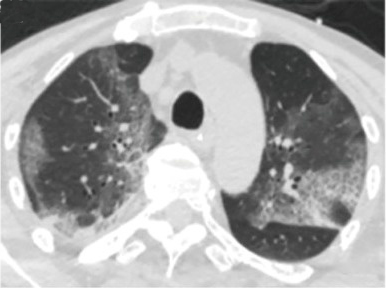

In [6]:
Image(images_train[1])
Image(images_train[15])
Image(images_train[66])

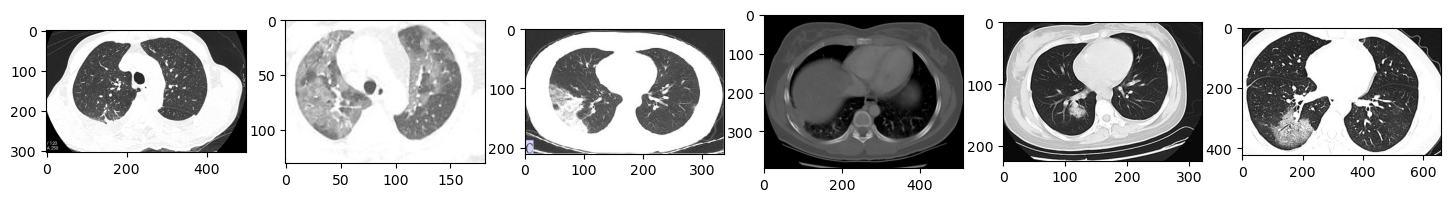

In [7]:
im = [cv2.imread(images_train[i]) for i in range(6)]

fig,ax = plt.subplots(ncols=6, figsize=(18,6))
for i in range(len(im)):
    ax[i].imshow(im[i],cmap='gray')

plt.show()

In [8]:
print(f'Number of samples in each set (train, val, test): {len(y_train), len(y_val), len(y_test)}')

print(f'Number of positive samples in each set: {y_train.sum(), y_val.sum(), y_test.sum()}')

Number of samples in each set (train, val, test): (447, 149, 150)
Number of positive samples in each set: (207, 71, 71)


### Dataset Class



In [9]:
class CT_Dataset(Dataset):
    def __init__(self, img_path, img_labels, img_transforms=None, grayscale=False):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)
        if (img_transforms is None) & (grayscale == True):
            self.transforms = transforms.Compose([transforms.Grayscale(),
                                                  transforms.Resize((250, 250)),
                                                  transforms.ToTensor()])
        elif grayscale == False:
            self.transforms = transforms.Compose([transforms.Resize((250, 250)),
                                                  transforms.ToTensor()])
        else:
            self.transforms = img_transforms
    
    def __getitem__(self, index):
        # load image
        cur_path = self.img_path[index]
        cur_img = PIL.Image.open(cur_path).convert('RGB')
        cur_img = self.transforms(cur_img)

        return cur_img, self.img_labels[index]
    
    def __len__(self):
        return len(self.img_path)

## 2. Model Development

### 2.1 Network Configuration

The model used for this exercise has several key layers:


*   Conv2D $\rightarrow$ Batch Normalization $\rightarrow$ ReLU Activation $\rightarrow$ AvgPooling2D
  * Output Channels: 64
  * Filter Size: 3x3
  * AvgPooling Filter Size: 2x2
*   Conv2D $\rightarrow$ Batch Normalization $\rightarrow$ ReLU Activation $\rightarrow$ AvgPooling2D
  * Output Channels: 128
  * Filter Size: 3x3
  * AvgPooling Filter Size: 2x2
*   Conv2D $\rightarrow$ Batch Normalization $\rightarrow$ ReLU Activation $\rightarrow$ AvgPooling2D
  * Output Channels: 256
  * Filter Size: 3x3
  * AvgPooling Filter Size: 2x2
*   Conv2D $\rightarrow$ Batch Normalization $\rightarrow$ ReLU Activation $\rightarrow$ AvgPooling2D
  * Output Channels: 512
  * Filter Size: 3x3
  * AvgPooling Filter Size: 2x2
*   Conv2D $\rightarrow$ Batch Normalization $\rightarrow$ ReLU Activation $\rightarrow$ AvgPooling2D $\rightarrow$ Flatten
  * Output Channels: 512
  * Filter Size: 3x3
  * AvgPooling Filter Size: 2x2
  * Output Shape (After Flatten): (Batch Size, 1600)

After the series of convolutions, we pass the parameters through a series of Dropout, Linear, and ReLU layers and produce an output of shape (Batch Size, 1)
*   Dropout $\rightarrow$ Linear $\rightarrow$ ReLU Activation $\rightarrow$ Dropout $\rightarrow$ Linear $\rightarrow$ ReLU Activation $\rightarrow$ Linear $\rightarrow$ ReLU Activation $\rightarrow$ Linear
  * Dropout Ratio: 0.5

### ConvNet

In [10]:
# define CNN mode
class Convnet(nn.Module):
    
    def __init__(self, dropout=0.5):
        super(Convnet, self).__init__()
        self.convnet = nn.Sequential(
          # input (num_batch, 1, 250, 250)
          nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),  # (num_batch, 64, 248, 248)
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 64, 124, 124)

          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3), # (num_batch, 128, 122, 122)
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 128, 61, 61)

          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3), # (num_batch, 256, 59, 59)
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 256, 29, 29)

          nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3), # (num_batch, 128, 27, 27)
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 128, 13, 13)

          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3), # (num_batch, 64, 11, 11)
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 64, 5, 5)
          nn.Flatten() # (num_batch, 1600)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),  # Dropout before first linear layer since it has a large number of trainable parameters
            nn.Linear(in_features= 12800, out_features=512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=1)
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

### ResNet101

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet101(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet101, self).__init__()
        self.resnet101 = models.resnet101(pretrained=True)
        in_features = self.resnet101.fc.in_features
        self.resnet101.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet101(x)
# Instantiate the ResNet101 model
model_resnet101 = ResNet101()

# Example usage: passing a dummy input through the model
dummy_input = torch.randn(32, 3, 250, 250)  # Example input: (batch_size, channels, height, width)
output = model_resnet101(dummy_input)

# Print the output shape
print("Output shape:", output.shape)


c:\Users\Lucas\anaconda3\envs\torch000\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\torch000\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output shape: torch.Size([32, 1])


### EfficientNetB4

In [12]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class EfficientNetB4(nn.Module):
    def __init__(self, num_classes=1):
        super(EfficientNetB4, self).__init__()
        self.effnet = EfficientNet.from_pretrained('efficientnet-b4')
        in_features = self.effnet._fc.in_features
        self.effnet._fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.effnet(x)


### EfficientNetB7

In [13]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class EfficientNetB7(nn.Module):
    def __init__(self, num_classes=1):
        super(EfficientNetB7, self).__init__()
        self.effnet = EfficientNet.from_pretrained('efficientnet-b7')
        in_features = self.effnet._fc.in_features
        self.effnet._fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.effnet(x)


### VGG16

In [14]:
import torch
import torch.nn as nn
import torchvision.models as models

class VGG16(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        in_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.vgg16(x)


### Verificação dos modelos

In [15]:
# # Instantiate the EfficientNetB4 model
# model_efficientnet_b4 = EfficientNetB4()

# # Instantiate the EfficientNetB7 model
# model_efficientnet_b7 = EfficientNetB7()

# # Instantiate the VGG16 model
# model_vgg16 = VGG16()

# # Example usage: passing a dummy input through the models
# dummy_input = torch.randn(32, 3, 250, 250)  # Example input: (batch_size, channels, height, width)
# output_b4 = model_efficientnet_b4(dummy_input)
# output_b7 = model_efficientnet_b7(dummy_input)
# output_vgg16 = model_vgg16(dummy_input)

# # Print the output shapes
# print("EfficientNetB4 Output shape:", output_b4.shape)
# print("EfficientNetB7 Output shape:", output_b7.shape)
# print("VGG16 Output shape:", output_vgg16.shape)


#### Print model summary to  visualize network structure

In [16]:
# vision_model = Convnet()
# summary(vision_model, (32, 1, 250, 250))

### 2.2 Model Training Procedure
The training sequence used for our CNN model is summarized below:


*   **Loss Function**: *Binary Cross Entropy w/ Logistic Loss*
*   **Optimizer**: *Adam Optimization*
  * To fight overfitting the following methods were used:
      * **L2 Regularization**: Weight regularization using L2 Norm
      * **Learning Schedule**: *Decrease the learning rate* over a set period of epochs

Parameters used for training:


*   **Initial Learning Rate**: 0.0002
*   Learning Schedule: 
  * **Gamma**: 0.5
  * **Patience**: 7 epochs
*   **Number of Epochs**: 35
*   **Batch Size**: 32
*   **L2 Weight Decay**: 0.09


In [17]:
# define training function

def train_model(model, train_dataset, val_dataset, test_dataset, device, 
                lr=0.0001, epochs=30, batch_size=32, l2=0.00001, gamma=0.5,
                patience=7):
    model = model.to(device)

    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # set up loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)  # pass in the parameters to be updated and learning rate
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=patience, gamma=gamma)

    # Training Loop
    print("Training Start:")
    for epoch in range(epochs):
        model.train()  # start to train the model, activate training behavior

        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        for i, (images, labels) in enumerate(train_loader):
            # reshape images
            images = images.to(device)  # reshape: from (128, 1, 28, 28) -> (128, 28 * 28) = (128, 284), move batch to device
            labels = labels.to(device)  # move to device
            # forward
            outputs = model(images).view(-1)  # forward
            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)
    
            cur_train_loss = criterion(outputs, labels)  # loss
            cur_train_acc = (pred == labels).sum().item() / batch_size

            # backward
            cur_train_loss.backward()   # run back propagation
            optimizer.step()            # optimizer update all model parameters
            optimizer.zero_grad()       # set gradient to zero, avoid gradient accumulating

            # loss
            train_loss += cur_train_loss 
            train_acc += cur_train_acc
        
        # valid
        model.eval()  # start to train the model, activate training behavior
        with torch.no_grad():  # tell pytorch not to update parameters
            for images, labels in val_loader:
                # calculate validation loss
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images).view(-1)

                # loss
                cur_valid_loss = criterion(outputs, labels)
                val_loss += cur_valid_loss
                # acc
                pred = torch.sigmoid(outputs)
                pred = torch.round(pred)
                val_acc += (pred == labels).sum().item() / batch_size

        # learning schedule step
        scheduler.step()

        # print training feedback
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_loader)

        print(f"Epoch:{epoch + 1} / {epochs}, lr: {optimizer.param_groups[0]['lr']:.5f} train loss:{train_loss:.5f}, train acc: {train_acc:.5f}, valid loss:{val_loss:.5f}, valid acc:{val_acc:.5f}")
    
        # update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
    
    test_acc = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(images)

            # the class with the highest energy is what we choose as prediction
            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)
            test_acc += (pred == labels).sum().item()

    print(f'Test Accuracy:  {(test_acc / len(test_loader))}')

    return history, model

Process the datasets and train the model

In [18]:
print("Current GPU memory usage:", torch.cuda.memory_allocated() / (1024 ** 2), "MB")
print("Max GPU memory usage:", torch.cuda.max_memory_allocated() / (1024 ** 2), "MB")

torch.cuda.empty_cache()

Current GPU memory usage: 0.0 MB
Max GPU memory usage: 0.0 MB


In [19]:
65165wecwec

SyntaxError: invalid decimal literal (2257872392.py, line 1)

In [20]:


# Load the data
train_dataset = CT_Dataset(img_path=images_train, img_labels=y_train)
val_dataset = CT_Dataset(img_path=images_val, img_labels=y_val)
test_dataset = CT_Dataset(img_path=images_test, img_labels=y_test)

batch_size = 32
epoch = 100

# # Train the ResNet101 model
# model_resnet101 = ResNet101()
# histResNet101, modelResNet101 = train_model(model_resnet101, train_dataset, val_dataset, test_dataset, device, lr=0.0002, batch_size= batch_size, epochs=epoch, l2=0.09, patience=5)

# Train the EfficientNetB4 model
model_efficientnet_b4 = EfficientNetB4()
hist_EfficientNetB4, model_EfficientNetB4 = train_model(model_efficientnet_b4, train_dataset, val_dataset, test_dataset, device, lr=0.0002, batch_size= batch_size, epochs=epoch, l2=0.09, patience=5)

# # Train the EfficientNetB7 model
# model_efficientnet_b7 = EfficientNetB7()
# hist_EfficientNetB7, model_EfficientNetB7 = train_model(model_efficientnet_b7, train_dataset, val_dataset, test_dataset, device, lr=0.0002, batch_size= batch_size, epochs=epoch, l2=0.09, patience=5)

# # Train the VGG16 model
# model_vgg16 = VGG16()
# hist_VGG16, model_VGG16 = train_model(model_vgg16, train_dataset, val_dataset, test_dataset, device, lr=0.0002, batch_size= batch_size, epochs=epoch, l2=0.09, patience=5)

Loaded pretrained weights for efficientnet-b4
Training Start:
Epoch:1 / 100, lr: 0.00020 train loss:0.68467, train acc: 0.57366, valid loss:0.69420, valid acc:0.50625
Epoch:2 / 100, lr: 0.00020 train loss:0.66578, train acc: 0.65848, valid loss:0.69324, valid acc:0.51875
Epoch:3 / 100, lr: 0.00020 train loss:0.64338, train acc: 0.68973, valid loss:0.69414, valid acc:0.44375
Epoch:4 / 100, lr: 0.00020 train loss:0.60198, train acc: 0.73438, valid loss:0.69409, valid acc:0.44375
Epoch:5 / 100, lr: 0.00010 train loss:0.52837, train acc: 0.79688, valid loss:0.69386, valid acc:0.44375
Epoch:6 / 100, lr: 0.00010 train loss:0.46130, train acc: 0.84821, valid loss:0.69282, valid acc:0.44375
Epoch:7 / 100, lr: 0.00010 train loss:0.40481, train acc: 0.87277, valid loss:0.69126, valid acc:0.44375
Epoch:8 / 100, lr: 0.00010 train loss:0.34805, train acc: 0.91741, valid loss:0.69253, valid acc:0.44375
Epoch:9 / 100, lr: 0.00010 train loss:0.30572, train acc: 0.91964, valid loss:0.69750, valid acc:0

In [21]:
label_model = "EfficientNetB4_2"
hist_kernel = hist_EfficientNetB4
model_kernel = model_EfficientNetB4

In [22]:
# torch.save(model.state_dict(), 'C:/Users/Lucas/PIBIC/model_NIG-CHEST/trained_model.pth')
torch.save(model_kernel.state_dict(), f'C:/Users/Lucas/PIBIC/model_pytorch_/{label_model}.pth')
# torch.save(model_EfficientNetB4.state_dict(), 'C:/Users/Lucas/PIBIC/model_NIG-CHEST/trained_model_EfficientNetB4.pth')
# torch.save(model_EfficientNetB7.state_dict(), 'C:/Users/Lucas/PIBIC/model_NIG-CHEST/trained_model_EfficientNetB7.pth')
# torch.save(model_VGG16.state_dict(), 'C:/Users/Lucas/PIBIC/model_NIG-CHEST/trained_model_VGG16.pth')



## Metricis

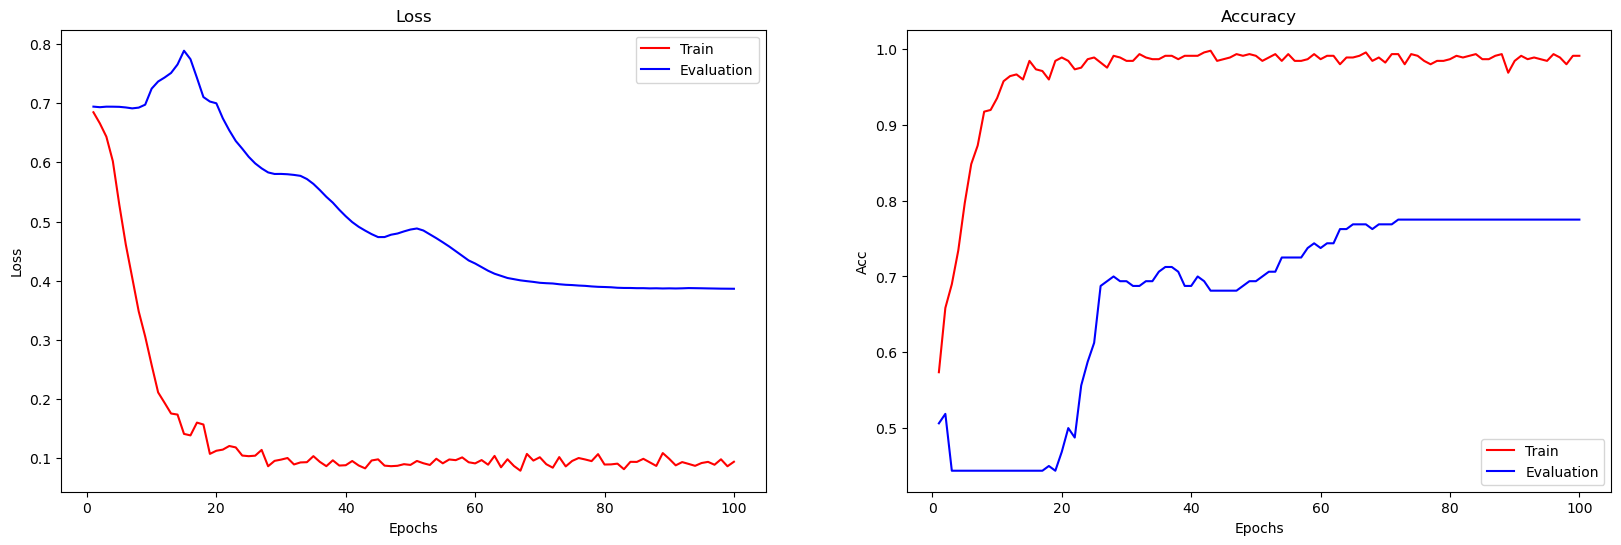

In [23]:
def plot_metrics(hist, label_model) :
    # plot training curves
    epochs = range(1, len(hist['train_loss']) + 1)

    train_loss = [t.cpu().detach().numpy() for t in hist['train_loss']]
    val_loss = [t.cpu().detach().numpy() for t in hist['val_loss']]


    fig, ax = plt.subplots(1,2, figsize=(20,6))
    ax[0].plot(epochs, train_loss, 'r-', label='Train')
    ax[0].plot(epochs, val_loss, 'b-', label='Evaluation')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    plt.savefig(f'C:/Users/Lucas/PIBIC/model_pytorch_/metrics/loss{label_model}.png')  # This saves the plot as a PNG image

    ax[1].plot(epochs, hist['train_acc'], 'r-', label='Train')
    ax[1].plot(epochs, hist['val_acc'], 'b-', label='Evaluation')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Acc')
    ax[1].legend()
    plt.savefig(f'C:/Users/Lucas/PIBIC/model_pytorch_/metrics/accuracy{label_model}.png')  # This saves the plot as a PNG image
    

    plt.show()
    
    
plot_metrics(hist_kernel, label_model)

In [24]:
def calculate_metrics(model, test_dataset, device, plot_images=False):
    # Initialize variables to store predictions and ground truth
    y_true = []
    y_pred = []
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions)

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate evaluation metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (fn + tp)

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'specificity': specificity,
        'sensitivity': sensitivity
    }

    return metrics





model_path = f'C:/Users/Lucas/PIBIC/model_pytorch_/{label_model}.pth'

if label_model[:6] == "ResNet":
    model_kernel = ResNet101()
elif label_model[:14] == "EfficientNetB4":
    model_kernel = EfficientNetB4()
elif label_model[:14] == "EfficientNetB7":
    model_kernel = EfficientNetB7()
elif label_model[:5] == "VGG16":
    model_kernel = VGG16()

model_kernel.load_state_dict(torch.load(model_path))
model_kernel.to(device)  # Move the model to the specified device
model_kernel.eval()  # Set the model to evaluation mode

# Call the function with plot_images=True to plot images
metrics = calculate_metrics(model_kernel, test_dataset, device, plot_images=True)
metrics

Loaded pretrained weights for efficientnet-b4


{'precision': 0.7654320987654321,
 'recall': 0.8732394366197183,
 'f1_score': 0.8157894736842104,
 'accuracy': 0.8133333333333334,
 'specificity': 0.759493670886076,
 'sensitivity': 0.8732394366197183}

In [25]:
pd.DataFrame(metrics.items(), columns=['Metric', 'Value']).to_csv(f'C:/Users/Lucas/PIBIC/model_pytorch_/metrics/{label_model}.csv')

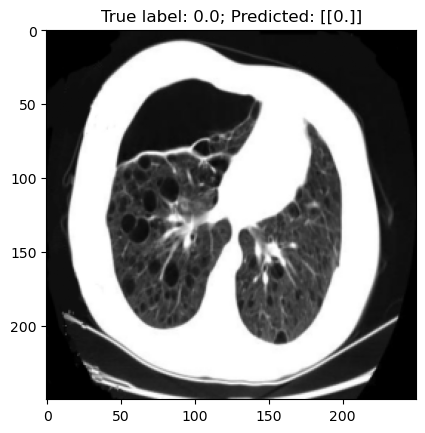

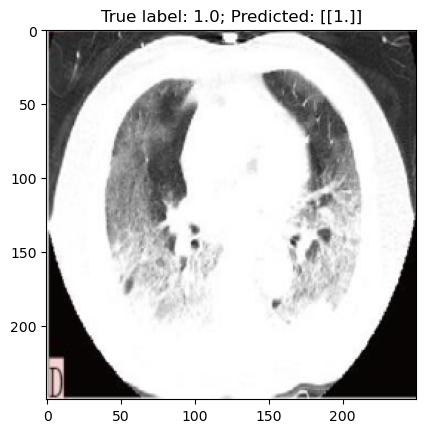

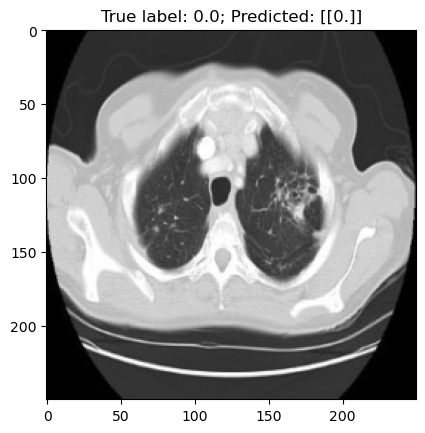

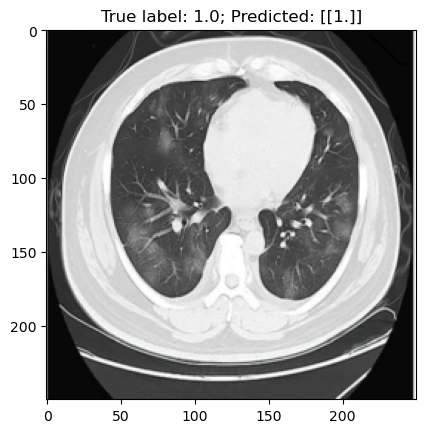

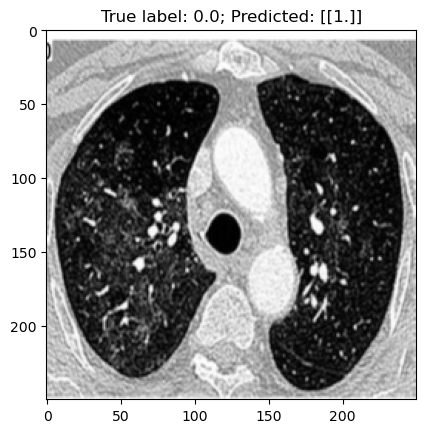

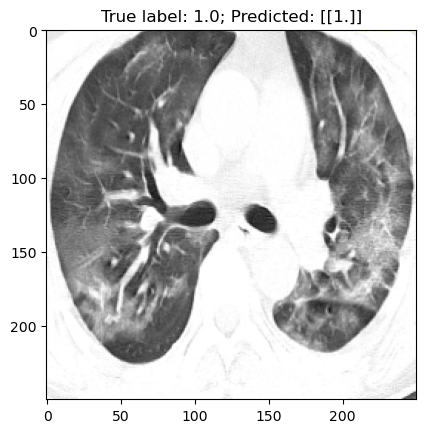

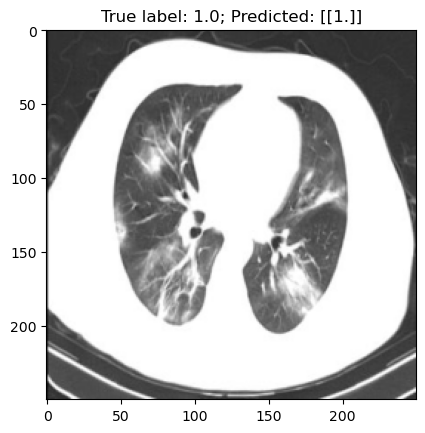

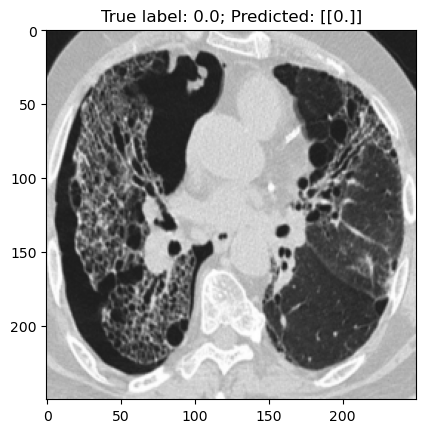

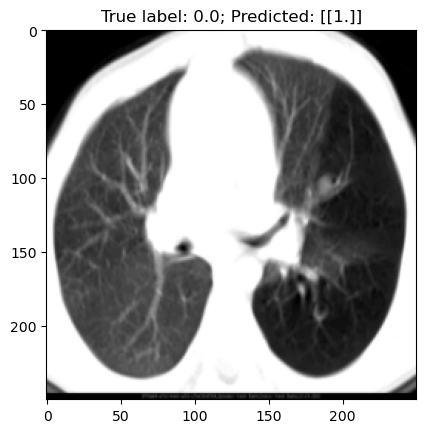

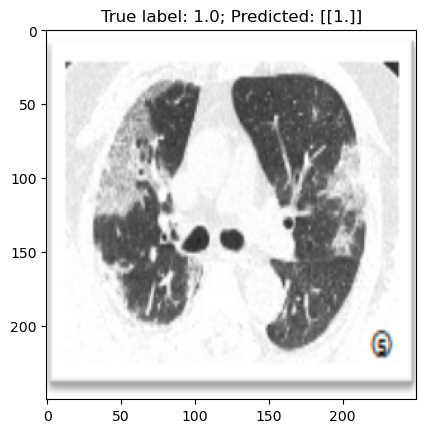

In [26]:
def process_images(model, test_dataset, device, plot_images=False, num_images_to_plot=10):
    # Initialize variables to store predictions and ground truth
    y_pred = []
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    images_plotted = 0  # Counter for the number of images plotted

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            y_pred.extend(predictions)

            # Plot images with true and predicted labels
            if plot_images and images_plotted < num_images_to_plot:
                plot_image(images, labels, predictions)
                images_plotted += 1

            # Break the loop if the desired number of images is plotted
            if images_plotted >= num_images_to_plot:
                break


def plot_image(images, true_label, predicted_label):
    if len(images.shape) == 4 and images.shape[1] == 3:
        # Convert CUDA tensor to numpy array and rearrange dimensions for RGB image
        images = images.cpu().detach().numpy().squeeze().transpose((1, 2, 0))
    else:
        # Convert CUDA tensor to numpy array and squeeze if necessary
        images = images.cpu().detach().numpy().squeeze()

    if len(images.shape) == 2:
        plt.imshow(images, cmap='gray')
    else:
        plt.imshow(images)
    
    # Format the labels
    true_label = true_label.item() if isinstance(true_label, torch.Tensor) else true_label
    predicted_label = predicted_label.item() if isinstance(predicted_label, torch.Tensor) else predicted_label
    
    plt.title(f'True label: {true_label}; Predicted: {predicted_label}')
    plt.show()
    
    
process_images(model_kernel, test_dataset, device, plot_images=True)

**Sugestão de Próximos Passos**

1. Colocar para salvar o modelo com a menor validation loss.
2. Colocar código para carregar o modelo salvo e fazer predições em imagens do dataset.
3. Criar métricas de acurácia (Accuracy, Precision, Recall, F-score, etc.) para avaliar o dataset de teste com o modelo salvo.

Quando tudo estiver pronto:
4. Criar novos modelos CNN (começar pela ResNet101).
5. Implementar outros modelos.

Quando estiver pronto:
6. Implementar no seu dataset.


Para binário tem que mudar a loss (CrossEntropy), a sigmoid da layer final para softmax

# Materiais e Métodos

## 1. Datasets

Explicação sobre os conjuntos de dados utilizados.

## 2. Modelos

Explicação sobre como funciona um modelo CNN (Convolutional Neural Network) e os parâmetros utilizados.

### 2.1. EfficientNet

### 2.2. ResNet101

...

## 3. Métricas
